In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
import cv2
from skimage import io
from tqdm import tqdm

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [2]:
class CFG:
    ori_sam_model = {
        "model_type" : 'vit_b',
        'checkpoint' : 'work_dir/SAM/sam_vit_b_01ec64.pth',
        'device' : 'cuda:0'
    }
    
    medsam = {
        "model_type" : 'vit_b',
        'checkpoint' : 'work_dir/demo2D/Our_Model/sam_model_best_waffer.pth',
        'device' : 'cuda:0'
    }

In [3]:
# multiimages

In [3]:
# read ground truth (gt should have the same name as the image) and simulate a bounding box
def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])


In [4]:
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

In [7]:
def show(ts_img_path, ts_gt_path, multi = True):
    """
    To predict and save many images to use for comparision between models
    Args:
        ts_img_path (str): Path to the input folder
        ts_gt_path (str): Path to the ground truth folder
        multi (bool): Status to predict and save (Default is True)
    """
    #datatest
    test_names = sorted(os.listdir(ts_img_path))
    
    def predict_save(img_idx):                             
        # select a test case
        print('Image ', img_idx)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "")
        image_data = io.imread(join(ts_img_path, test_names[img_idx]))
        if image_data.shape[-1]>3 and len(image_data.shape)==3:
            image_data = image_data[:,:,:3]
        if len(image_data.shape)==2:
            image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
    
        gt_data = io.imread(join(ts_gt_path, test_names[img_idx]), as_gray=True)
        bbox_raw = get_bbox_from_mask(gt_data)
        
        # preprocess: cut-off and max-min normalization
        lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
        image_data_pre = np.clip(image_data, lower_bound, upper_bound)
        image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
        image_data_pre[image_data==0] = 0
        image_data_pre = np.uint8(image_data_pre)
        H, W, _ = image_data_pre.shape
    
        # load the original SAM model
        ori_sam_model = sam_model_registry[CFG.ori_sam_model['model_type']](checkpoint=CFG.ori_sam_model['checkpoint']).to(CFG.ori_sam_model['device'])
        ori_sam_predictor = SamPredictor(ori_sam_model)
        
        # predict the segmentation mask using the original SAM model
        ori_sam_predictor.set_image(image_data_pre)
        ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)
    
        #load medsam
        sam_model = sam_model_registry[CFG.medsam['model_type']](checkpoint=CFG.medsam['checkpoint']).to(CFG.medsam['device'])
        
        # predict the segmentation mask using the fine-tuned model
        # resize image to 3*1024*1024
        sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
        resize_img = sam_transform.apply_image(image_data_pre)
        resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
        input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
        assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'
        
        with torch.no_grad():
            # pre-compute the image embedding
            ts_img_embedding = sam_model.image_encoder(input_image)
            # convert box to 1024x1024 grid
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            bbox = sam_trans.apply_boxes(bbox_raw, (H, W))
            print(f'{bbox_raw=} -> {bbox=}')
            box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
            
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
            medsam_seg_prob, _ = sam_model.mask_decoder(
                image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
                image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
                sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
                dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
                multimask_output=False,
                )
            medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
            # convert soft mask to hard mask
            medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
            medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
            print(medsam_seg.shape)
    
        #metric
        ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
        medsam_dsc = compute_dice_coefficient(gt_data>0, cv2.resize(medsam_seg, (gt_data.shape))>0)
    
        #plot
        fig, axs = plt.subplots(1, 3, figsize=(25, 25))
        axs[0].imshow(image_data)
        show_mask(gt_data>0, axs[0])
        # show_box(box_np[img_id], axs[0])
        axs[0].set_title('Ground Truth', fontsize=20)
        axs[0].axis('off')
        
        axs[1].imshow(image_data)
        show_mask(ori_sam_seg, axs[1])
        show_box(bbox_raw, axs[1])
        # add text to image to show dice score
        axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=15, horizontalalignment='left', verticalalignment='top', color='yellow')
        axs[1].set_title('Mask with Untuned Model', fontsize=20)
        axs[1].axis('off')
        
        axs[2].imshow(image_data)
        show_mask(cv2.resize(medsam_seg, (gt_data.shape)), axs[2])
        show_box(bbox_raw, axs[2])
        # add text to image to show dice score
        axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=15, horizontalalignment='left', verticalalignment='top', color='yellow')
        axs[2].set_title('Mask with Tuned Model', fontsize=20)
        axs[2].axis('off')
        plt.show()  
        plt.subplots_adjust(wspace=0.01, hspace=0)
        # save plot
        fig.savefig(join('data/result/2024_03_10/Wafer/1024/Result_Test_Image_' + str(img_idx).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
        plt.close(fig)

        print('Done with Image', test_names[idx])

    if multi:
        pbar = tqdm(test_names)
        for idx, filename in enumerate(pbar):
            predict_save(idx)
    else:
        idx = int(input('Enter ID Image '))
        assert idx < len(test_names), 'The ID Image must smaller than the length of Test Folder'
        predict_save(idx)       
    


In [6]:
pwd

'D:\\medsam\\MedSAM-0.1'

In [9]:
%cd data/result

D:\medsam\MedSAM-0.1\data\result


C:\Users\Admin\.conda\envs\medsam\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
%mkdir Power_Semiconductor

A subdirectory or file Power_Semiconductor already exists.


In [13]:
%mkdir 2024_05_03
%mkdir 2024_03_05
%cd 2024_03_05

A subdirectory or file 2024_05_03 already exists.


D:\medsam\MedSAM-0.1\data\result\2024_03_05


In [14]:
%mkdir Power_Semiconductor

In [19]:
%cd .. 

D:\medsam\MedSAM-0.1


In [7]:
#excute

  0%|          | 0/4 [00:00<?, ?it/s]

Image  0
bbox_raw=array([  27,   21,  990, 1006], dtype=int64) -> bbox=array([[  27,   21,  990, 1006]], dtype=int64)
(256, 256)


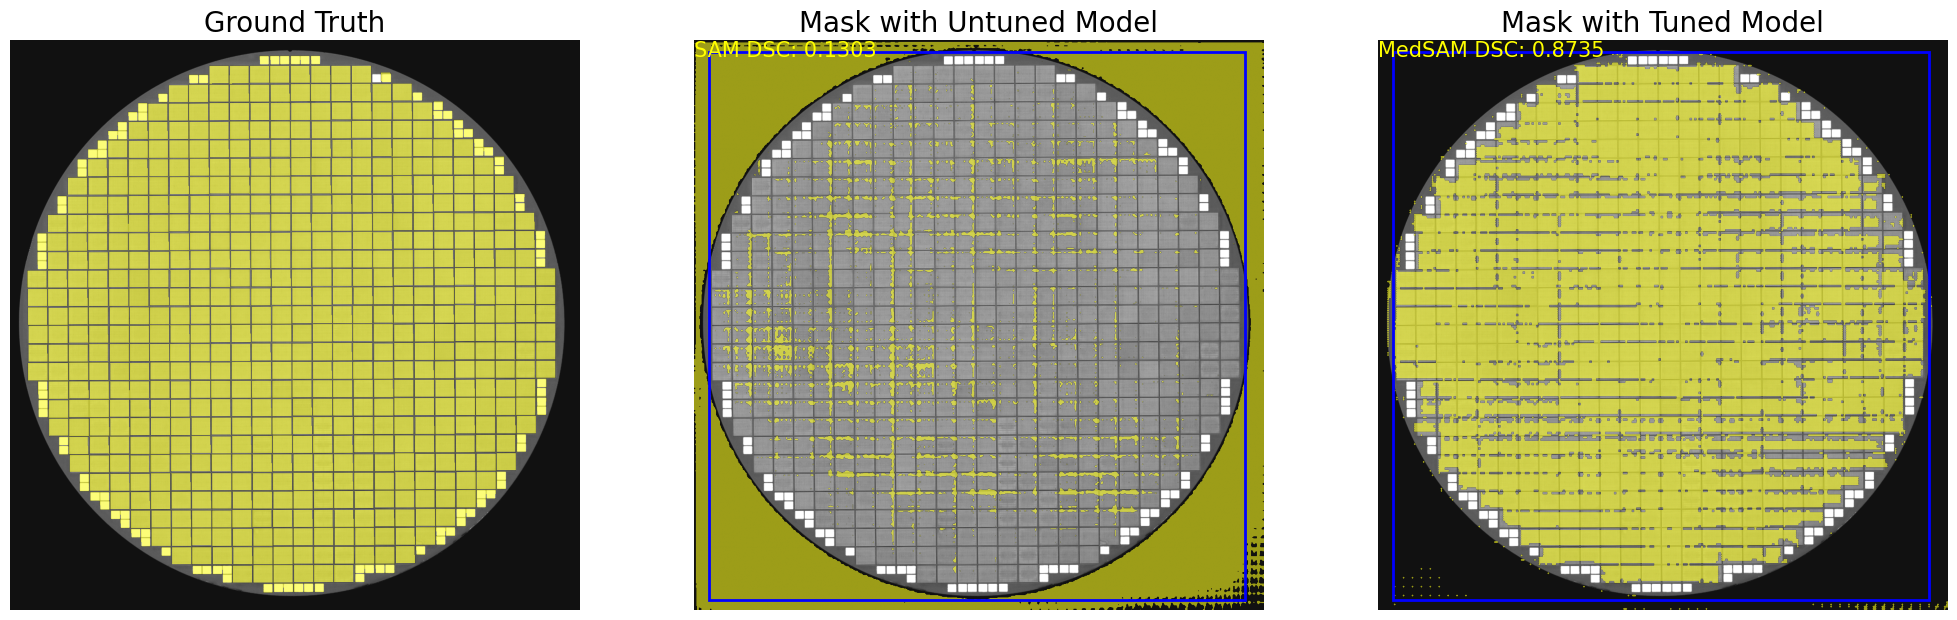

 25%|██▌       | 1/4 [00:05<00:15,  5.29s/it]

Done with Image Image_(2).png
Image  1
bbox_raw=array([ 26,  27, 994, 993], dtype=int64) -> bbox=array([[ 26,  27, 994, 993]], dtype=int64)
(256, 256)


<Figure size 640x480 with 0 Axes>

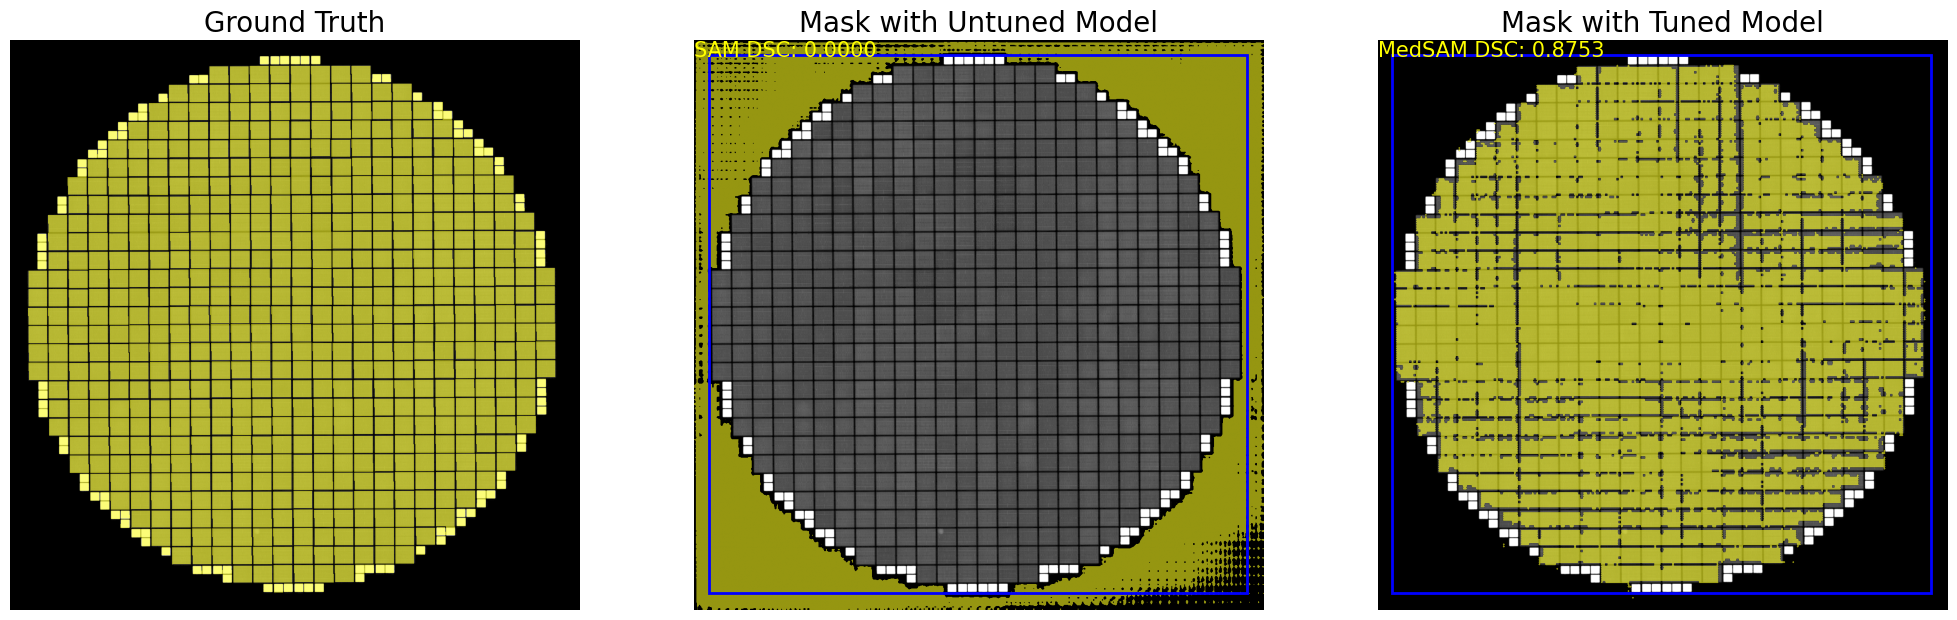

 50%|█████     | 2/4 [00:10<00:09,  4.97s/it]

Done with Image Image_(3).png
Image  2
bbox_raw=array([  12,   17,  989, 1003], dtype=int64) -> bbox=array([[  12,   17,  989, 1003]], dtype=int64)
(256, 256)


<Figure size 640x480 with 0 Axes>

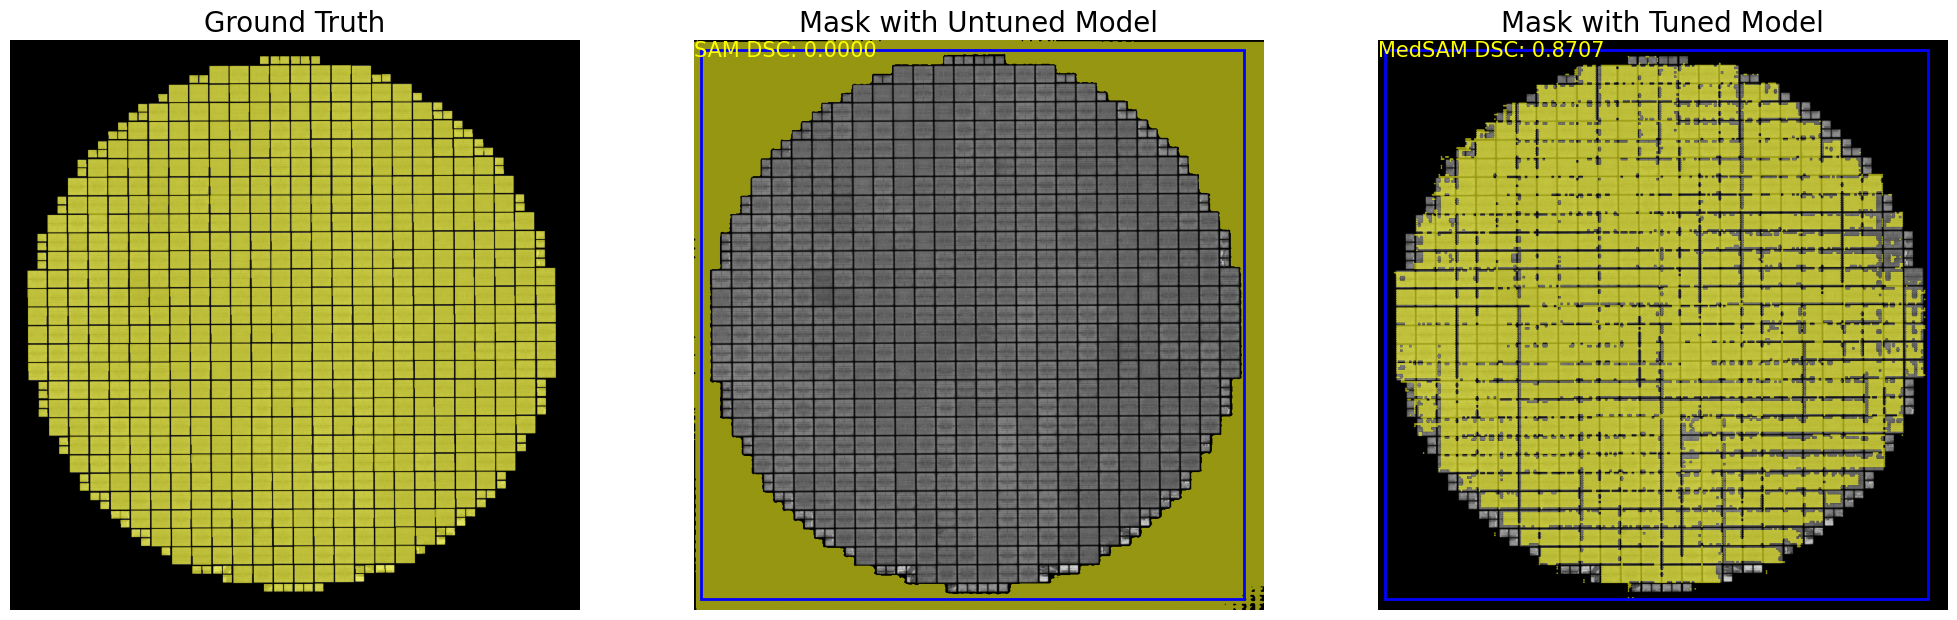

 75%|███████▌  | 3/4 [00:14<00:04,  4.90s/it]

Done with Image Image_(4).png
Image  3
bbox_raw=array([  26,   27,  994, 1001], dtype=int64) -> bbox=array([[  26,   27,  994, 1001]], dtype=int64)
(256, 256)


<Figure size 640x480 with 0 Axes>

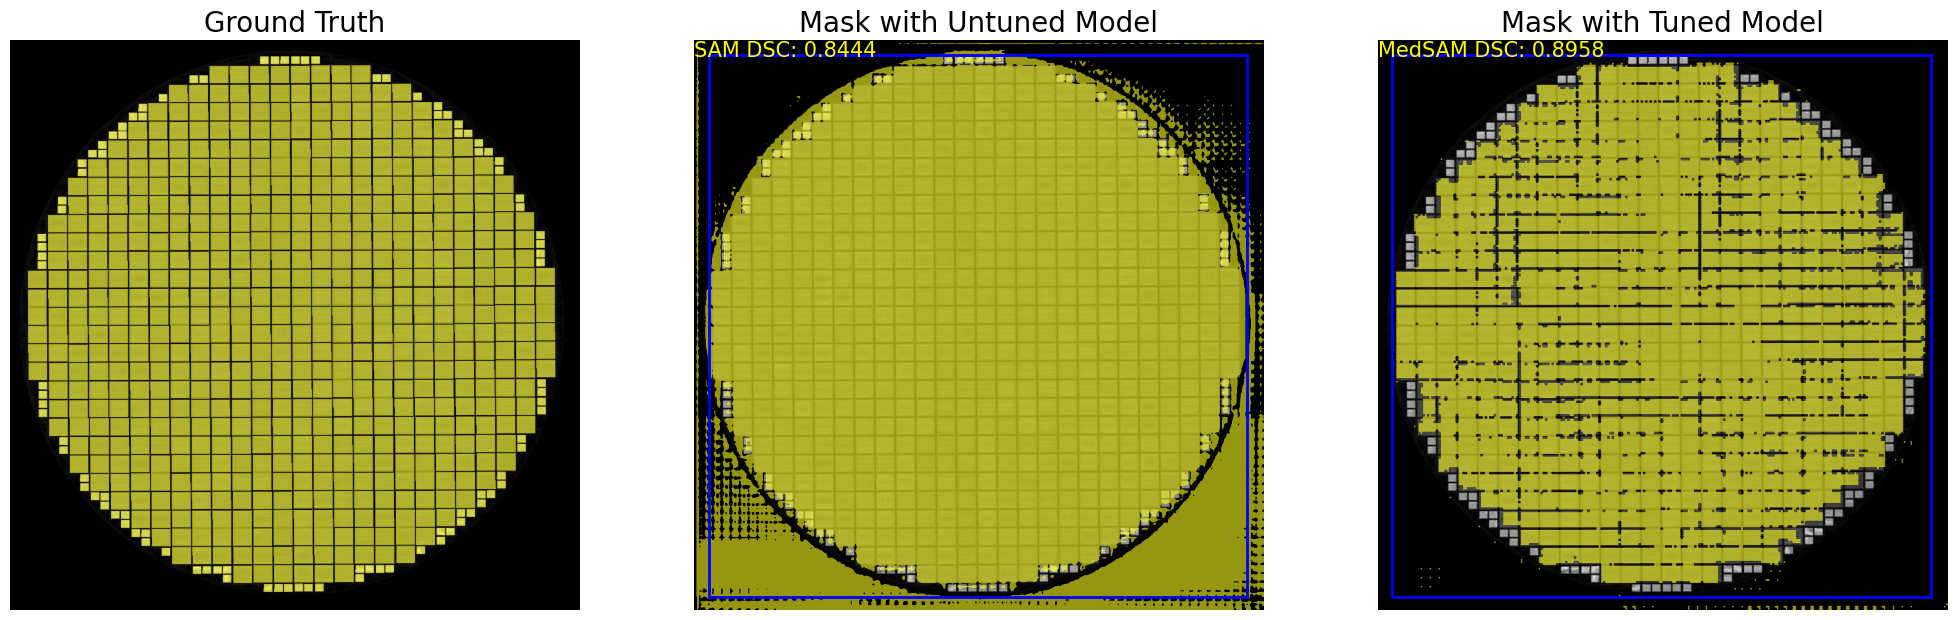

100%|██████████| 4/4 [00:19<00:00,  4.89s/it]

Done with Image Image_(5).png


<Figure size 640x480 with 0 Axes>

In [10]:
#datatest
ts_img_path = 'data/sam/2024_03_10/Wafer/1024/images'
ts_gt_path = 'data/sam/2024_03_10/Wafer/1024/labels'
show(ts_img_path, ts_gt_path)